In [1]:
# Talib is not necessary but some people may like using talib for convenience
# import talib as ta

!pip install pytz
!pip install MetaTrader5
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import itertools
import MetaTrader5 as mt5
import pytz
import matplotlib as py
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Connect to MetaTrader5

In [3]:
# Uses MetaTrader5 to fetch data
# We use MetaTrader5 because it is able to fetch more data than Yahoo Finance in certain instruments
initilized = mt5.initialize()

if initilized:
    print('Connected to MetaTrader5')
    print('Login:', mt5.account_info().login)
    print('Server:', mt5.account_info().server)

Connected to MetaTrader5
Login: 30668876
Server: GrowthNext-Demo


## Setting parameters and retrieving data

In [4]:
symbol = "XAUUSD"
timeframes = mt5.TIMEFRAME_M10
gmt_now = datetime.now(pytz.timezone('Etc/GMT'))
lot_size = 0.1

In [5]:
#testing for 365 days which is 
raw = pd.DataFrame(mt5.copy_rates_from(symbol, timeframes, gmt_now, 4000))
raw['time'] = pd.to_datetime(raw['time'], unit='s', errors='coerce')
raw.drop(columns=['open','tick_volume', 'real_volume'], inplace=True)
raw.set_index('time', inplace=True)

## Applying returns

In [6]:
raw = raw.copy()
raw["pips"] = (raw["close"] - raw["close"].shift(1))
raw = raw.dropna()

## Apply strategy (SMA)

In [7]:
# This strategy uses SMA 7,28,100,200 crossovers

df = raw.copy()
df["SMA_7"] = df["close"].rolling(7).mean()
df["SMA_28"] = df["close"].rolling(28).mean()
df["SMA_100"] = df["close"].rolling(100).mean()
df["SMA_200"] = df["close"].rolling(200).mean()

In [8]:
# Define conditions
condition_1 = (df["SMA_7"] > df["SMA_28"]) & (df["SMA_100"] > df["SMA_200"])
condition_2 = (df["SMA_7"] < df["SMA_28"]) & (df["SMA_100"] < df["SMA_200"])

# Update position_sma column
df.loc[:, "position_sma"] = np.select([condition_1, condition_2], [1, -1], default=0)

df = df.dropna()

In [9]:
# Ensure there are 0, -1, 1 in the column otherwise it might hint that the strategy has faults
df["position_sma"].value_counts()

position_sma
 0    1863
 1    1544
-1     393
Name: count, dtype: int64

## Calculating pip returns base on strategy

In [10]:
df["strategy"] = df["pips"] * df["position_sma"]
df["cumulative"] = df["strategy"].cumsum()
df["cumulative"].describe()

count    3800.000000
mean       94.304771
std        59.055800
min        -0.440000
25%        68.945000
50%        84.880000
75%       132.242500
max       222.770000
Name: cumulative, dtype: float64

### Finding total number of transitions & commission costs

In [11]:
transitions_0_to_1 = ((df["position_sma"] == 1) & (df["position_sma"].shift(1) == 0)).sum()
transitions_0_to_minus_1 = ((df["position_sma"] == -1) & (df["position_sma"].shift(1) == 0)).sum()
transitions_1_to_0 = ((df["position_sma"] == 0) & (df["position_sma"].shift(1) == 1)).sum()
transitions_minus_1_to_0 = ((df["position_sma"] == 0) & (df["position_sma"].shift(1) == -1)).sum()
transitions_1_to_minus_1 = ((df["position_sma"] == -1) & (df["position_sma"].shift(1) == 1)).sum()
transitions_minus_1_to_1 = ((df["position_sma"] == 1) & (df["position_sma"].shift(1) == -1)).sum()

# Calculate total counts
total_transitions = transitions_0_to_1 + transitions_0_to_minus_1 + transitions_1_to_0 + transitions_minus_1_to_0 + transitions_1_to_minus_1 + transitions_minus_1_to_1

print("Total transitions:", total_transitions)
print("Transitions from 0 to 1:", transitions_0_to_1)
print("Transitions from 0 to -1:", transitions_0_to_minus_1)
print("Transitions from 1 to 0:", transitions_1_to_0)
print("Transitions from -1 to 0:", transitions_minus_1_to_0)
print("Transitions from 1 to -1:", transitions_1_to_minus_1)
print("Transitions from -1 to 1:", transitions_minus_1_to_1)


Total transitions: 199
Transitions from 0 to 1: 74
Transitions from 0 to -1: 26
Transitions from 1 to 0: 73
Transitions from -1 to 0: 26
Transitions from 1 to -1: 0
Transitions from -1 to 1: 0


### Finding total profits less commission costs

In [12]:
contract_size = 100
pip_value = lot_size*contract_size

#Resampling data
data = df.copy()

#data_resampled_count = pd.DataFrame(data.resample('D').count()["position_sma"])
spread_costs = round(data['spread'].mean()) / 100
total_spread_costs = spread_costs * total_transitions * pip_value

data_resampled = pd.DataFrame(data.resample('D').sum()["strategy"])
data_resampled = data_resampled[data_resampled["strategy"] != 0]
data_days = data_resampled["strategy"].count()

#Commissions
commission = 2*lot_size
total_commission = commission*total_transitions
total_commission_f = "{:.2f}".format(total_commission)

#Calculating mean, highest, lowest net profits
Trades_per_day = round(total_transitions / data_days) #Avg trades per day
spreads_cost_day = (Trades_per_day * spread_costs)    #Average total spread costs per day
data_resampled["strategy_cost"] = data_resampled["strategy"] - spreads_cost_day

highest_win = round(data_resampled["strategy_cost"].max()) * pip_value
lowest_win = round(data_resampled["strategy_cost"].min()) * pip_value
nprofit_mean = round(data_resampled["strategy_cost"].mean()) * pip_value
stddev = round(data_resampled["strategy_cost"].std()) * pip_value
nprofit_highest = round(nprofit_mean + stddev)
nprofit_lowest = round(nprofit_mean - stddev)

#Profit after costs
net_f = (data_resampled["strategy_cost"].sum() * pip_value) - total_commission
net = "{:.2f}".format(net_f)

#win rate
condition_4 = data_resampled["strategy_cost"] > 0
data_resampled['positive_days'] = np.where(condition_4, 1, 0)
data_resampled['positive_days'].sum()
win_rate = (data_resampled['positive_days'].sum()/data_days)*100
win_rate = round(win_rate)

### Plot theoretical returns vs actual returns

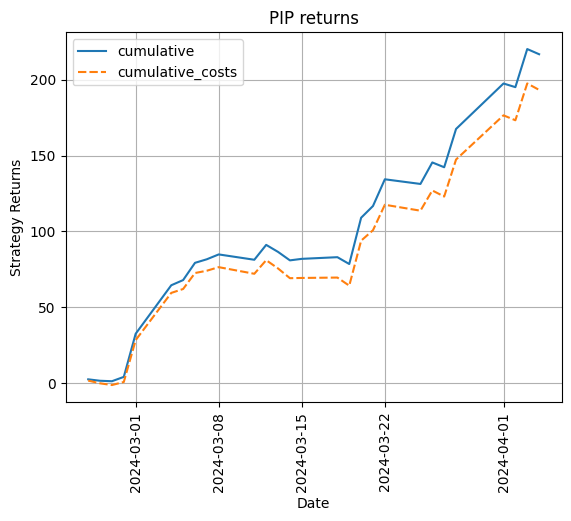

In [17]:
data_resampled["cumulative"] = data_resampled["strategy"].cumsum()
data_resampled["cumulative_costs"] = data_resampled["strategy_cost"].cumsum()

sns.lineplot((data_resampled["cumulative"],data_resampled["cumulative_costs"]), color='green')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Strategy Returns')
plt.title("PIP returns")
plt.grid(True)

## Conducting Value at risk

In [14]:
var_data = data_resampled.copy()
var_data['Position'] = range(1, len(var_data) + 1)
var_data = var_data.sort_values("strategy",ascending = True)

#Taking 10% VaR positions
conservative = math.floor(len(var_data) * 0.05) 
formal = math.ceil(len(var_data) * 0.05)        

# Note: If 0.05 * Total rows return an integer both conservative & formal will
# return similar values hence not required to do interpolation


#Probability * Sample size
alpha_s = 0.05 * len(var_data)

# Finding the respective lowest daily return
return_c = var_data['strategy'].iloc[conservative]
return_f = var_data['strategy'].iloc[formal]

#Smoothing parameter for giving recent data higher weights
# 0 < delta < 1
delta = 0.95 

init_weight = (1 - delta) / (1 - delta**len(var_data))
init_weight # W0

0.06560189415333853

## Interpolation (Weighted Historical Simulation)

In [15]:
#If position equals to conservative/formal which is 50 in this case
condition_conservative = return_c == var_data['strategy']
condition_formal = return_f == var_data['strategy']

#Hence return & store the daily_return of the aforementioned position
value_c = var_data.loc[condition_conservative, 'Position'].values
value_f = var_data.loc[condition_formal, 'Position'].values
value_c = value_c[0] # 145th
value_f = value_f[0] # 161th

con_w = init_weight * (delta ** value_c)
for_w = init_weight * (delta ** value_f)

weighted_return_c = con_w * return_c
weighted_return_f = for_w * return_f

#interpolation

interpolate = (value_f - alpha_s) * weighted_return_c + (alpha_s - value_c) * weighted_return_f

var_final = interpolate * pip_value
var_final = format(var_final, ".2f")
print(var_final)

-9.97


### Summary


Instrument: XAUUSD
Timeframe: 10min
Strategy: SMA

Net Profits: $1894.00

Days = 28 business days

Highest profit day = $310.0
Lowest profit  day = $-60.0

== Overal Statistics ==
Total Transactions: 199
Total Spread Costs: $239
Total Commissions: $39.80

Strategy Win-Rate = 64%

== Per Day Statistics ==
Trades Per Day = 7
Expected Net Profits: $70.0
Highest Expected Net Profits: $190
Lowest Expected Net Profits: $-50
Standard Deviation: $120.0
Value At Risk = $-9.97



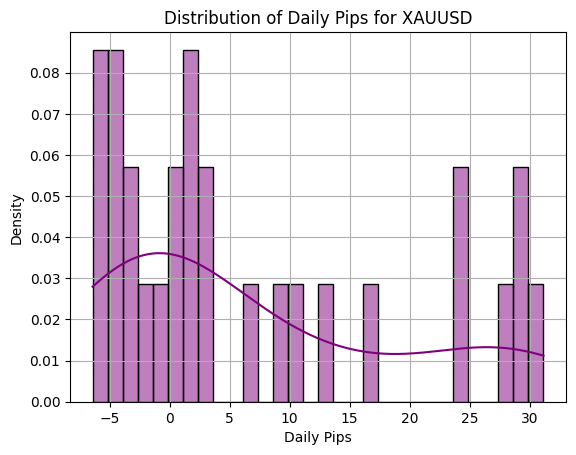

In [16]:
print("""
Instrument: {}
Timeframe: {}min
Strategy: SMA

Net Profits: ${}

Days = {} business days

Highest profit day = ${}
Lowest profit  day = ${}

== Overal Statistics ==
Total Transactions: {}
Total Spread Costs: ${}
Total Commissions: ${}

Strategy Win-Rate = {}%

== Per Day Statistics ==
Trades Per Day = {}
Expected Net Profits: ${}
Highest Expected Net Profits: ${}
Lowest Expected Net Profits: ${}
Standard Deviation: ${}
Value At Risk = ${}
""".format(symbol, timeframes, net, data_days, highest_win, lowest_win,
           total_transitions, round(total_spread_costs), total_commission_f, win_rate, 
           Trades_per_day, nprofit_mean, nprofit_highest, nprofit_lowest, stddev, var_final))

sns.histplot(data_resampled['strategy_cost'], bins=30, kde=True, color='purple', stat='density')
plt.xlabel('Daily Pips')
plt.ylabel('Density')
plt.title('Distribution of Daily Pips for {}'.format(symbol))
plt.grid(True)
plt.show()